<a name="top"></a>
<br/>
# Understanding how `medGAN` works on the MIMIC-III dataset of shape (46 520, 1 071) with binary values

Author: [Sylvain Combettes](https://github.com/sylvaincom). <br/>
Last update: Sep 11, 2019. Creation: Aug 12, 2019. <br/>
My own `medGAN` repository: [medgan-tips](https://github.com/sylvaincom/medgan-tips) (based on Edward Choi's work). <br/>
Edward Choi's original repository: [medgan](https://github.com/mp2893/medgan).

The final goal of my project is to use `medGAN` on my own dataset (patient data). Hence, I first need to understand how the `medGAN` program works. In this notebook, I provide code cells and explanations to help better understand and run `medGAN`. Because there are some confidentiality issues with the MIMIC-III dataset, I cleared the output of the cells.

Before reading this notebook, make sure that you have read my [medGAN repository](https://github.com/sylvaincom/medgan-tips)'s table of contents.

We will use the MIMIC-III dataset and process it so that we only have binary values.

---
### Table of contents

- [1) Loading the MIMIC-III dataset](#load-mimic)
- [2) Using `process_mimic.py` and `medgan.py` to generate the fake realistic data](#run)
- [3) How can one interpret the output of `medgan.py`?](#gen-samples)
- [4) How can one interpret the output of `process_mimic.py`?](#input)
- [5) Comparing the fictitious generated samples to the real-life original ones](#comparison)

---
### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import pickle

---
<a name="load-mimic"></a>
# 1) Loading the MIMIC-III dataset

## 1.1) `ADMISSIONS.csv`

In [2]:
df_adm = pd.read_csv("ADMISSIONS.csv")
print(df_adm.shape)
df_adm.head()

(129, 19)


,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,12258,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,2164-10-23 16:43:00,2164-10-23 23:00:00,SEPSIS,0,1
1,12263,10011,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,2126-08-28 18:59:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,HEPATITIS B,1,1
2,12265,10013,165520,2125-10-04 23:36:00,2125-10-07 15:13:00,2125-10-07 15:13:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,NaN,UNKNOWN/NOT SPECIFIED,NaN,NaN,SEPSIS,1,1
3,12269,10017,199207,2149-05-26 17:19:00,2149-06-03 18:42:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,2149-05-26 12:08:00,2149-05-26 19:45:00,HUMERAL FRACTURE,0,1
4,12270,10019,177759,2163-05-14 20:43:00,2163-05-15 12:00:00,2163-05-15 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,NaN,NaN,ALCOHOLIC HEPATITIS,1,1


Do we have a lot of missing values?

In [4]:
def observe_missing_values(df):
    # This function does not return any values.
    
    dico = {}
    c_index = [] # index of columns of features with missing values
    n,p = df.shape
    features = list(df) # list of features
    
    # We compute the percentage of missing values for each column:
    for f in features:
        percentage = round(sum(df[f].isna())*100/n, 2) # percentage of missing values
        if percentage>0:
            dico[f] = [percentage]
            c_index.append(df.columns.get_loc(f))
    
    if c_index == []:
        return 'There are no missing values!'
    
    # We construct the DataFrame ordered by Approx. missing values (%):
    df_mv = pd.DataFrame(data=dico) # mv for missing values
    idx_rename = {df_mv.index.tolist()[0]:'Approx. missing values (%)'}
    df_mv = df_mv.rename(index=idx_rename)
    
    # We print the features with a decreasing Approx. missing values (%) value:
    n_f = min(p,10) # number of features we choose to print
    df_mv_ordered = df_mv.sort_values(by=['Approx. missing values (%)'], axis=1, ascending=False)
    print('The', n_f, 'features with the most missing values are:')
    print(df_mv_ordered.iloc[0].head(n_f))
    
    # We plot the Approx. missing values (%) given the index of the feature:
    plt.plot(c_index, df_mv.iloc[0], 'o')
    plt.xlabel('Index of feature')
    plt.ylabel('Approx. missing values (%)')
    plt.title('Observing missing values')
    plt.show()

The 10 features with the most missing values are:
deathtime         68.99
language          37.21
edouttime         28.68
edregtime         28.68
marital_status    12.40
religion           0.78
Name: Approx. missing values (%), dtype: float64


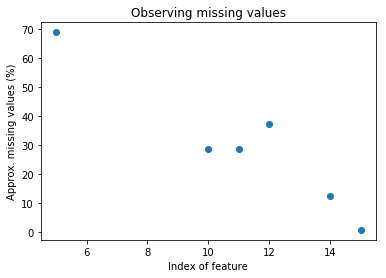

In [5]:
observe_missing_values(df_adm)

## 1.2) `DIAGNOSES_ICD.csv`

In [6]:
df_ICD = pd.read_csv('DIAGNOSES_ICD.csv')
print(df_ICD.shape)
df_ICD.head()

(1761, 5)


,row_id,subject_id,hadm_id,seq_num,icd9_code
0,112344,10006,142345,1,99591
1,112345,10006,142345,2,99662
2,112346,10006,142345,3,5672
3,112347,10006,142345,4,40391
4,112348,10006,142345,5,42731


Do we have a lot of missing values?

In [7]:
observe_missing_values(df_ICD)

'There are no missing values!'

In [9]:
print(df_ICD.columns)


Index(['row_id', 'subject_id', 'hadm_id', 'seq_num', 'icd9_code'], dtype='object')


We check if our dataset is balanced. Does one `ICD9_CODE` appear distinctly more than others in proportion?

In [10]:
df_ICD['icd9_code'].value_counts(normalize=True).head()

4019     0.030097
42731    0.027257
5849     0.025554
4280     0.022147
25000    0.017604
Name: icd9_code, dtype: float64

---
# 2) Using `process_mimic.py` and `medgan.py` to generate the fake realistic data <a name="run"></a>

This step is detailed in my tutorial [A few additional tips on how to run Edward Choi's medGAN](https://github.com/sylvaincom/medgan/blob/master/tips-for-medgan.md).

In short, in the Anaconda prompt, we run:
```
cd C:\Users\<username>\Documents\mimic_binary
python process_mimic.py ADMISSIONS.csv DIAGNOSES_ICD.csv training-data "binary"
mkdir generated
python medgan.py training-data.matrix ./generated/samples --data_type="binary"
python medgan.py training-data.matrix gen-samples --model_file=./generated/samples-999 --generate_data=True --data_type="binary"
```
Some default values are `n_epoch=1000`, `n_pretrain_epoch=100` and `batch_size=1000`. We choose `nSamples=10000` line 405 in `medgan.py`.
The computing took more than 5 hours on my laptop.

---
# 3) How can one interpret the output of `medgan.py`? <a name="gen-samples"></a>

We load the `gen-samples.npy` file which is `medgan.py`'s output:

In [11]:
fict = np.load('generated_data.npy') # fictitious generated dataset
df_fict = pd.DataFrame(fict)
print(df_fict.shape)
df_fict.head()

(10000, 295)


,0,1,2,3,4,5,6,7,8,9,...,285,286,287,288,289,290,291,292,293,294
0,0.008392,0.951111,0.352463,0.005488,0.001839,0.010842,0.563059,0.987201,0.710980,0.357321,...,0.013504,0.011661,0.002382,0.025693,0.006138,0.021498,0.008742,0.000197,0.000284,0.000309
1,0.006269,0.959975,0.224599,0.007466,0.002995,0.003302,0.016831,0.990903,0.992072,0.720935,...,0.061671,0.006417,0.003053,0.023392,0.037798,0.054109,0.006337,0.002450,0.009433,0.001124
2,0.005430,0.062713,0.854577,0.000959,0.000343,0.000368,0.017055,0.856542,0.652910,0.830030,...,0.025955,0.053288,0.001931,0.001697,0.003462,0.048063,0.006408,0.013123,0.003561,0.041948
3,0.001041,0.984914,0.991958,0.002419,0.000962,0.003744,0.085180,0.227652,0.992268,0.999730,...,0.001160,0.040096,0.013943,0.001728,0.001041,0.006969,0.001066,0.016366,0.028727,0.021067
4,0.016635,0.858133,0.043095,0.006997,0.042109,0.025772,0.341851,0.998547,0.013538,0.770825,...,0.019843,0.122736,0.013783,0.042202,0.008191,0.012282,0.000358,0.007487,0.001020,0.014270


Do the output of `medgan.py` have missing values?

In [12]:
observe_missing_values(df_fict)

'There are no missing values!'

The output of `medgan.py` has no missing values!

Some questions about this data frame:
* What do the columns correspond to? They are not the ones of `ADMISSIONS.csv` nor `DIAGNOSIS_ICD.csv`.
* What do the rows correspond to?
* Why are the values not binary?

We can find some answers in an issue opened in Edward Choi's GitHub: [How to interpret the samples?](https://github.com/mp2893/medgan/issues/3). In order to understand the output `gen-samples.npy` of `medgan.py`, we are going to go back to the input of `medgan.py` which is the output of `process_mimic.py`: `training-data.matrix`.

Actually, in `gen-samples.npy`, as in the `training-data.matrix` file, each row corresponds to a single patient and each column corresponds to a specific ICD9 diagnosis code. We can use the `training-data.types` file created by `process_mimic.py` to map each column to a specific ICD9 diagnosis code. Read the beginning part of the source code of `process_mimic.py` for more information about these files:
```python
# Output files
# <output file>.pids: cPickled Python list of unique Patient IDs. Used for intermediate processing
# <output file>.matrix: Numpy float32 matrix. Each row corresponds to a patient. Each column corresponds to a ICD9 diagnosis code.
# <output file>.types: cPickled Python dictionary that maps string diagnosis codes to integer diagnosis codes.
```

What is ICD-9? See [ICD-9](https://en.wikipedia.org/wiki/International_Statistical_Classification_of_Diseases_and_Related_Health_Problems#ICD-9) and [List of ICD-9 codes](https://en.wikipedia.org/wiki/List_of_ICD-9_codes).

We need to round the values of the generated dataset ourselves:

In [13]:
df_fict = df_fict.round(0)
df_fict.head()

,0,1,2,3,4,5,6,7,8,9,...,285,286,287,288,289,290,291,292,293,294
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Indeed, in line 405 of `medgan.py`, we have chosen `nSamples=10000`. It is important to note that once we have learned the estimated density of the real-life original samples, we can generate as many fake realistic samples as we want.

---
# 4) How can one interpret the output of `process_mimic.py`? <a name="input"></a>

## 4.1) Understanding `training-data.types`

_cPickled Python dictionary that maps string diagnosis codes to integer diagnosis codes._

In [15]:
map_dict = pickle.load(open('mimic_binary.types', 'rb'))
print(type(map_dict))
print('An excerpt is:', dict(list(map_dict.items())[0:5]))

<class 'dict'>
An excerpt is: {'D_934': 50, 'D_42': 148, 'D_86': 136, 'D_5': 154, 'D_000': 245}


Thus, as its name suggests, `process_mimic.py` is really dependent on the MIMIC-III dataset. We will not use `process_mimic.py` on our own dataset and only run `medgan.py`. Out of `process_mimic.py`, we only need to understand how the output file `training-data.matrix` is constructed.

## 4.2) Understanding `training-data.pids`

_cPickled Python list of unique Patient IDs. Used for intermediate processing_

In [16]:
id_list = pickle.load(open('mimic_binary.pids', 'rb'))
print(type(id_list))
print('An excerpt is:', id_list[:10])

<class 'list'>
An excerpt is: [43779, 40456, 43735, 40204, 10006, 10011, 10013, 10117, 10017, 10019]


This list is not useful for our own dataset.

## 4.3) Understanding `training-data.matrix`

_Numpy float32 matrix. Each row corresponds to a patient. Each column corresponds to a ICD9 diagnosis code._

`training-data.matrix` is an output of `process_mimic.py` and the input of `medgan.py`.

In [17]:
real_data = pickle.load(open('mimic_binary.matrix', 'rb')) # real-life original dataset
print(type(real_data))
real_data

<class 'numpy.ndarray'>


array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.]], dtype=float32)

In [18]:
df_real = pd.DataFrame(real_data)
print(df_real.shape)
df_real.head(5)

(100, 295)


,0,1,2,3,4,5,6,7,8,9,...,285,286,287,288,289,290,291,292,293,294
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As we chose, the real-life data is binary. 

We can note that the input and the [output](#gen-samples) of `medgan.py` have the same number of columns and that the values are of the same type (binary). Thus, `gen-samples.npy` is a fictitious realistic generated dataset that is trying to estimate the data in the `training-data.matrix` file.

Does the input of `medgan.py` have missing values?

In [19]:
observe_missing_values(df_real)

'There are no missing values!'

The input of `medgan.py` has no missing values!

---
<a name="comparison"></a>
# 5) Comparing the fictitious generated samples to the real-life original ones

We wish to measure the accuracy of the fictitious generated dataset called `df_fict` considering the real-life original one called `df_real`. Is our fictitious generated dataset realistic?

Here is a recap of our parameters for `medGAN`:

| dataset | number of samples | number of features |
|---|---|---|
|`df_real` | 46 520 | 1 071 |
|`df_fict` | 10 000 | 1 071 |

| `n_epoch` | `n_pretrain_epoch` | `batch_size` | `nSamples` |
|---|---|---|---|
| 1 000 | 100 | 1 000 | 10 000 |

As in Choi's [paper](https://arxiv.org/abs/1703.06490), we use dimension-wise probability as a measure of accuracy. Indeed, the variables are binary. Given that our data is binary, for each feature (dimension), we claim that 1 corresponds to success and 0 to failure. Hence the proportion of 1s obtained is the Bernoulli success probability $p$.

## 5.1) Probability distribution of the real-life data

100 295


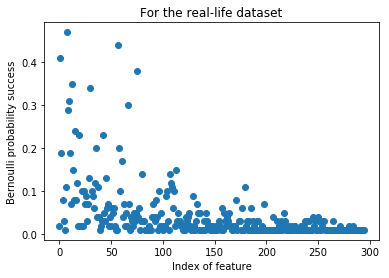

In [20]:
df_real = df_real
n_real, p_real = df_real.shape
print(n_real, p_real)

proba_real = [sum(df_real[f])/n_real for f in list(df_real)]

plt.plot(proba_real, 'o')
plt.xlabel('Index of feature')
plt.ylabel('Bernoulli probability success')
plt.title('For the real-life dataset')
plt.show()

## 5.2) Probability distribution of the fictitious generated data

10000 295


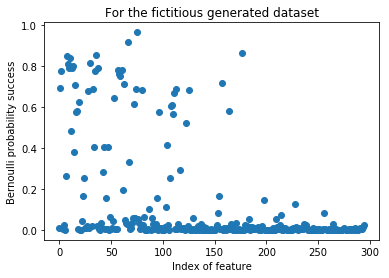

In [21]:
n_fict, p_fict = df_fict.shape
print(n_fict, p_fict)

proba_fict = [sum(df_fict[f])/n_fict for f in list(df_fict)]

plt.plot(proba_fict, 'o')
plt.xlabel('Index of feature')
plt.ylabel('Bernoulli probability success')
plt.title('For the fictitious generated dataset')
plt.show()

## 5.3) Comparison: dimension-wise probability

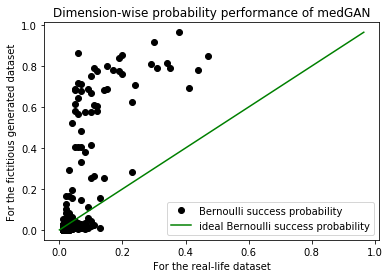

In [22]:
xaxis = proba_real
yaxis = proba_fict

start = min(np.min(xaxis), np.min(yaxis))
stop = max(np.max(xaxis), np.max(yaxis))
p = len(xaxis)
X = np.linspace(start, stop, num=p+1)

plt.plot(xaxis, yaxis, 'ok', X, X, '-g');

plt.legend(['Bernoulli success probability', 'ideal Bernoulli success probability'])
plt.title('Dimension-wise probability performance of medGAN')
plt.xlabel('For the real-life dataset')
plt.ylabel('For the fictitious generated dataset')
plt.savefig('accuracy_mimic_binary.png', dpi=120) # to save the image in high resolution
plt.show()

The values of the $x$-axis and the $y$-axis are ordered: we successively compare the Bernoulli success probability for both datasets (`df_real` and `df_fict`) for a given feature. For information, we have 1 071 features thus 1 071 scatter points.

The diagonal green line indicates the ideal performance where the real and the (fake) realistic generated data show identical proportions of 1s. Based on the graph, as the dots are close to the diagonal green line, we can say that `medGAN` has a really good performance. I recall that we have a total of 1 071 points so it does not matter if we have a few points that are far from the diagonal green line.

> *Experimental result* - **The synthesis of binary values using `medGAN` works.** <br/>
We have observed that `medGAN` can generate fictitious samples with binary values that are realistic.

> *Further work* - **We could quantify the accuracy of the generated dataset.** <br/>
Rather than observing the accuracy of `medGAN` on a graph, we could quantify the accuracy by computing the total error: the sum (on all features) of the squares of the Bernoulli success probability difference / error. Graphically, an individual error (for a given feature) is the distance from the dot to the diagonal green line. We can normalize this total error by dividing it by the total number of features. This normalized squared error is actually the [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) (mean squared error).
We do not compute the MSE here because we have nothing to compare its value to.

---
Back to [top](#top).